In [3]:
import os
import fnmatch
import datetime
from datetime import datetime
import json
import pandas as pd
from matplotlib import dates
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.neighbors import KNeighborsClassifier
from finta import TA
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
import requests
keys = open('./keys.txt', 'r').readlines()
alpha_vantage_key = keys[0].split(':')[1]
fmp_key = keys[1].split(':')[1]
data_for_plot = dict
def add_ratings_to_data(df: pd.DataFrame):
    df['rating'] = 'hold'
    df.loc[((df['open'] < df.shift(30)['open']) & (df['open'] < df.shift(100)['open']) & ((df.shift(30)['open'] - df['open']) / df['open'] * 100 > 20)), 'rating'] = 'mega buy'
    df.loc[((df['open'] < df.shift(30)['open']) & (df['open'] < df.shift(100)['open']) & ((df.shift(30)['open'] - df['open']) / df['open'] * 100 > 3)), 'rating'] = 'buy'
    df.loc[((df['open'] > df.shift(30)['open']) & (df['open'] > df.shift(100)['open']) & ((df['open'] - df.shift(30)['open']) / df['open'] * 100 > 20)), 'rating'] = 'mega sell'
    df.loc[((df['open'] > df.shift(30)['open']) & (df['open'] > df.shift(100)['open']) & ((df['open'] - df.shift(30)['open']) / df['open'] * 100 > 3)), 'rating'] = 'sell'
    df.drop(df.tail(100).index,inplace=True)
    return df

def train():
    # screen stocks into sectors, market cap sizes
    small_cap_url = f'https://financialmodelingprep.com/api/v3/stock-screener?marketCapMoreThan=300000000&marketCapLowerThan=2000000001&limit=3&apikey={fmp_key}'
    mid_cap_url = f'https://financialmodelingprep.com/api/v3/stock-screener?marketCapMoreThan=2000000000&marketCapLowerThan=10000000001&limit=3&apikey={fmp_key}'
    large_cap_url = f'https://financialmodelingprep.com/api/v3/stock-screener?marketCapMoreThan=10000000000&limit=3&apikey={fmp_key}'
    # find api that can screen by those

    # https://api-v2.intrinio.com/securities/screen
    # need to have top 3 of each sector(aka GICS group)/market cap pair
    training_stocks = {
        'Consumer Cyclical':[],
        'Energy':[],
        'Technology':[],
        'Industrials':[],
        'Financial Services':[],
        'Basic Materials':[],
        'Communication Services':[],
        'Consumer Defensive':[],
        'Healthcare':[],
        'Real Estate':[],
        'Utilities':[],
        'Industrial Goods':[],
        'Financial':[],
        'Services':[],
        'Conglomerates':[]
    }
    url = f'https://www.alphavantage.co/query?function=CONSUMER_SENTIMENT&datatype=csv&apikey={alpha_vantage_key}'
    data_sent = pd.read_csv(url, index_col='timestamp')
    for sector in training_stocks:
        url = small_cap_url + f'&sector={sector}'
        r = requests.get(url)
        data = r.json()
        for stock in data:
            training_stocks[sector].append(stock['symbol'])
        url = mid_cap_url + f'&sector={sector}'
        r = requests.get(url)
        data = r.json()
        for stock in data:
            training_stocks[sector].append(stock['symbol'])
        url = large_cap_url + f'&sector={sector}'
        r = requests.get(url)
        data = r.json()
        for stock in data:
            training_stocks[sector].append(stock['symbol'])
        time.sleep(3)
    # alpha vantage for stock data

    # we need take into account: 
    # sentiment, country, rsi, macd, 
    # earnings date, price, volume, fear index of overall market

    for sector in training_stocks:
        stocks = training_stocks[sector]
        for stock in stocks:
            data = get_and_clean_data(stock, data_sent)
            data = add_ratings_to_data(data)
            data.dropna(inplace=True)
            data.to_csv(f'./data/{stock}.csv')
            category = get_stock_category(stock)
            plot_data(data, stock)
            x = data.drop(['open', 'high', 'low', 'close', 'volume', 'rating'], axis=1)
            y = data['rating']
            X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1337)
            classifier = KNeighborsClassifier()
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            stats_str = f'Classifier: {category}_{stock}\nAccuracy: {accuracy}\n----------------------\n'
            file_name = f'{category}_{stock}'
            print(stats_str)
            open(f'./stats/{file_name}.txt', "w").write(stats_str)
            dump(classifier, f'./classifiers/{file_name}.classifier', compress=True)
            # when in predictor, run all 3 for each sector/cap and do majority voting to choose the result
def get_and_clean_data(stock, data_sent):
    time.sleep(5)
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&datatype=csv&adjusted=true&symbol={stock}&outputsize=full&apikey={alpha_vantage_key}'
    data = pd.read_csv(url, index_col='timestamp')
    url = f'https://www.alphavantage.co/query?function=CCI&time_period=60&datatype=csv&symbol={stock}&interval=daily&apikey={alpha_vantage_key}'
    data_cci = pd.read_csv(url, index_col='time')
    data_price = data.copy()
    data_rsi = TA.STOCHRSI(data)
    data_macd = TA.MACD(data)
    data_stoch = TA.STOCH(data)
    data_vzo = TA.VZO(data)
    data = data.join(data_rsi, how='left') 
    data = data.join(data_macd, how='left') 
    data = data.join(data_stoch, how='left') 
    data = data.join(data_vzo, how='left') 
    data = data.join(data_cci, how='left') 
    data = data.join(data_sent, how='left')
    data = data.drop(labels=['open', 'high', 'low', 'close', 'volume'], axis=1)
    scaler = preprocessing.MinMaxScaler() 
    scaled_values = scaler.fit_transform(data) 
    data.loc[:,:] = scaled_values
    data = data.join(data_price, how='left')
    data.interpolate(axis='columns', inplace=True)
    data.dropna(inplace=True)
    return data
def get_stock_category(stock):
    url = f'https://financialmodelingprep.com/api/v3/profile/{stock}?apikey={fmp_key}'
    data = requests.get(url).json()
    sector = data[0]['sector']
    cap = data[0]['mktCap']
    if cap > 10_000_000_000:
        cap = 'large'
    elif cap < 10_000_000_000 and cap > 2_000_000_000:
        cap = 'mid'
    else:
        cap = 'small'
    sector = sector.replace(' ', '')
    category = f'{sector}_{cap}'
    return category
def predict(stock):
    url = f'https://www.alphavantage.co/query?function=CONSUMER_SENTIMENT&datatype=csv&apikey={alpha_vantage_key}'
    data_sent = pd.read_csv(url, index_col='timestamp')
    data = get_and_clean_data(stock, data_sent)
    category = get_stock_category(stock)
    ratings = {
        'mega buy':0,
        'buy':0,
        'hold':0,
        'mega sell':0,
        'sell':0
    }
    for filename in os.listdir('./classifiers'):
        if fnmatch.fnmatch(filename, f'{category}*'):
            classifier : KNeighborsClassifier = load(filename)
            prediction = classifier.predict(data)
            ratings[prediction['rating']] += 1
    if list(ratings.values).count(max(ratings, key=ratings.get)) > 1:
        return 1 # 1 == Hold
    else:
        return max(ratings, key=ratings.get)
def plot_data(data: pd.DataFrame, stock):
    mega_buys = data.loc[lambda data: data['rating'] == 'buy']
    buys = data.loc[lambda data: data['rating'] == 'mega buy']
    mega_sells = data.loc[lambda data: data['rating'] == 'mega sell']
    sells = data.loc[lambda data: data['rating'] == 'sell']
    plt.figure(figsize=(30, 14))
    plt.plot(data.index, data.open)
    plt.plot(mega_buys.index, mega_buys.open, 'g*')
    plt.plot(buys.index, buys.open, 'go')
    plt.plot(mega_sells.index, mega_sells.open, 'r*')
    plt.plot(sells.index, sells.open, 'ro')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.title(stock)
    ax = plt.gca()
    ax.xaxis.set_minor_locator(dates.MonthLocator([1, 5, 9]))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(dates.YearLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
    #plt.gcf().autofmt_xdate()
    plt.savefig(f'./figs/training_data/{stock}.pdf')
    plt.show()

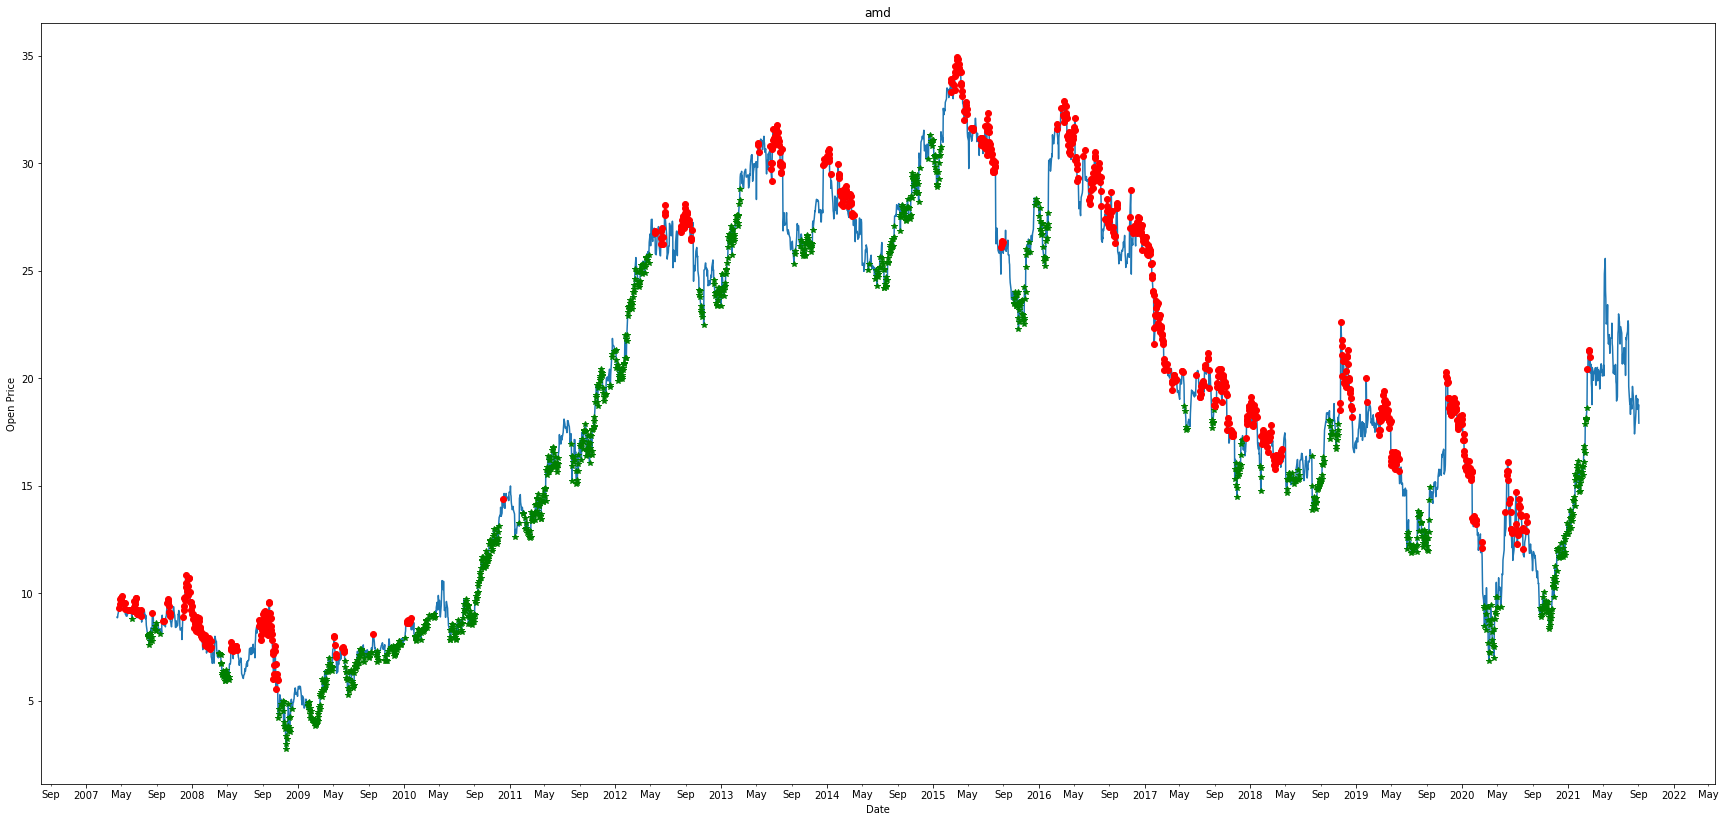

In [4]:
grf_data = pd.read_csv('./data/stock.csv', index_col='timestamp', parse_dates=True)
plot_data(add_ratings_to_data(grf_data), 'amd')